# Facial recognition to detect mood

`ML Facial recognition to detect mood and suggest songs accordingly`

### Dataset of 
* **Diminsion**:  48x48 pixel grayscale images of faces
* **Size**: consists of 28,709 examples and the public test set consists of 3,589 examples

* **Target:** (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set .

<div style="text-align: center;">
  <img src="face mood.png" width="500" height="200">
</div>

# Importing
### Import library

In [2]:
"""Import library""" 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50V2 as ResNet
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 28)

import random
import os

### Import dataset

In [3]:
# Function to extract images from folder and give folder name as target for image
def extractImages(datadir):
    # Get the data
    imagesData = []
    imagesLabel = []
    for folder in os.listdir(datadir):
        path = os.path.join(datadir, folder)
        for images in os.listdir(path):
            img = cv2.imread(os.path.join(path, images), cv2.IMREAD_GRAYSCALE)
            imagesData.append(img)
            imagesLabel.append(folder)
            
    # Shuffle data
    combined = list(zip(imagesData, imagesLabel))
    random.shuffle(combined)
    imagesData, imagesLabel = zip(*combined)
    
    return (imagesData, imagesLabel)

In [4]:
# Import train data
imagesTrainData = []
imagesTrainLabel = []
# train_data_dir = '/kaggle/input/fer2013/train'
train_data_dir = r'Data\train'

imagesTrainData, imagesTrainLabel = extractImages(train_data_dir)

print("number of image: ",len(imagesTrainData))        
print("shape of image:  ",imagesTrainData[1].shape)
print("labels:          ",list(set(imagesTrainLabel)))

number of image:  28709
shape of image:   (48, 48)
labels:           ['sad', 'happy', 'surprise', 'neutral', 'angry', 'disgust', 'fear']


In [5]:
# Import test data
imagesTestData = []
imagesTestLabel = []
#test_data_dir = '/kaggle/input/fer2013/test'
test_data_dir = r'Data\test'

imagesTestData, imagesTestLabel = extractImages(test_data_dir)

print("number of image: ",len(imagesTestData))        
print("shape of image:  ",imagesTestData[1].shape)
print("labels:          ",list(set(imagesTestLabel)))

number of image:  7178
shape of image:   (48, 48)
labels:           ['sad', 'happy', 'surprise', 'neutral', 'angry', 'disgust', 'fear']


---
# Data Exploring
### Show Dataset Image

In [6]:
# Show Image
def showImage (images,label,part):
    figure = plt.figure(figsize=((len(part)/10 + 1)*10, (len(part)/10 + 1)*2))
    j = 0
    for i in part:
        lbl = label[i]
        img = images[i]
        img = cv2.resize(img, (256, 256))
        figure.add_subplot(int(len(part)/10)+1, 10, j+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(lbl)
        j += 1

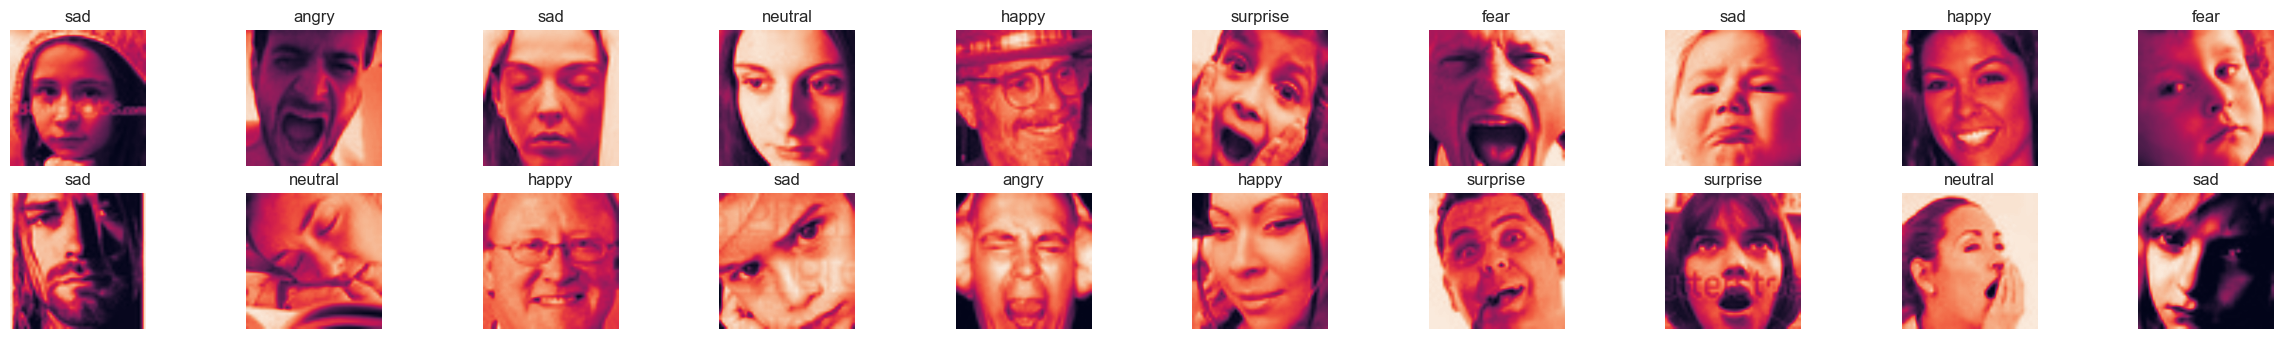

In [7]:
showImage(imagesTrainData,imagesTrainLabel, range(20))

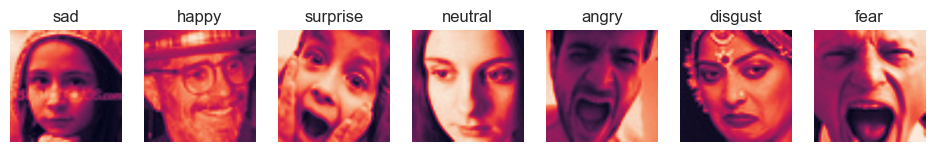

In [8]:
# Show one image from each class
unique_idx = [imagesTrainLabel.index(i) for i in list(set(imagesTrainLabel))]
showImage(imagesTrainData,imagesTrainLabel, unique_idx )

### Visualizing the Distribution of Images

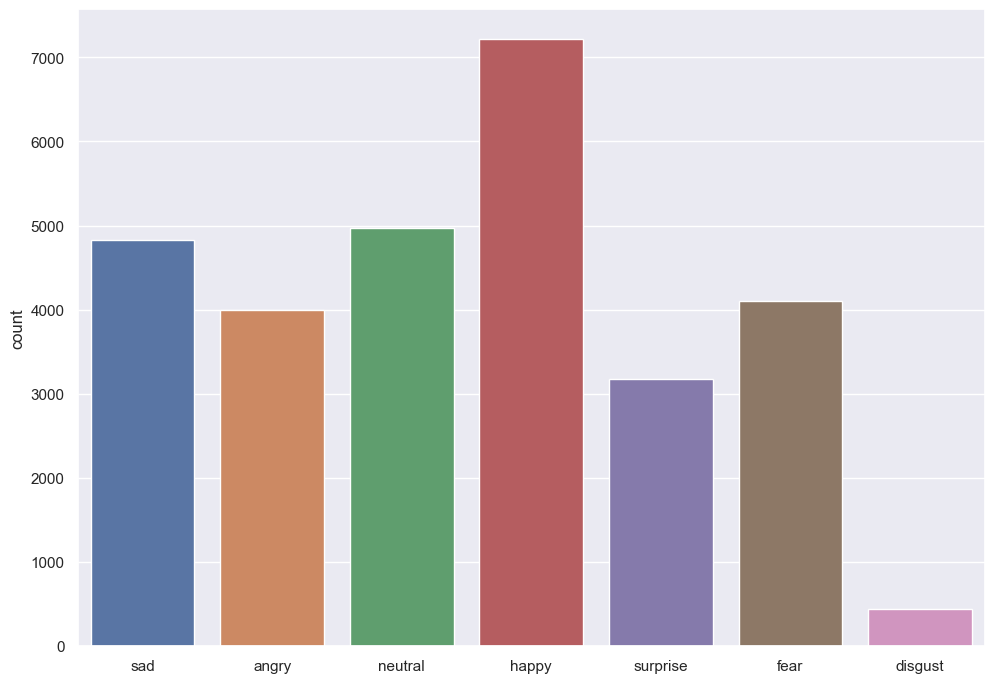

In [9]:
sns.countplot(x= list(imagesTrainLabel));

we can see unbalanced in `Disgust` class

---
# Preprocessing


### Encoding

In [10]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(imagesTrainLabel)
Y_test = label_encoder.transform(imagesTestLabel)

In [11]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

### Scaling

In [12]:
X_train = np.array(imagesTrainData)
X_test = np.array(imagesTestData)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(28709, 48, 48, 1)
(7178, 48, 48, 1)
(28709, 7)
(7178, 7)


In [13]:
X_train[0].shape

(48, 48, 1)

---
# CNN Model

In [14]:
def facial_recognition_detect_mood(input_shape=(48, 48, 1)):
    
    # Build model 
    model = Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.0001,), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [15]:
model = facial_recognition_detect_mood()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       36992     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [18]:
# Callback
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('facial_recognition_detect_mood.h5', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             verbose=1, 
                             mode='min')

earlyStopping = EarlyStopping(monitor='val_accuracy', 
                              mode='auto', 
                              verbose=1, 
                              patience=10, 
                              restore_best_weights=True)

reduceLr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

callbacks = [checkpoint,earlyStopping,reduceLr, LearningRateScheduler(step_decay)]

In [ ]:
# Image Augmentation 
aug = ImageDataGenerator(zoom_range=0.1,
                         rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)

hist = model.fit(aug.flow(X_train, Y_train, batch_size=64), batch_size=64, epochs=90, validation_data=(X_test, Y_test), callbacks=callbacks)

In [21]:
# First model i trained 
model.save('facial_recognition_detect_mood_v2.h5')

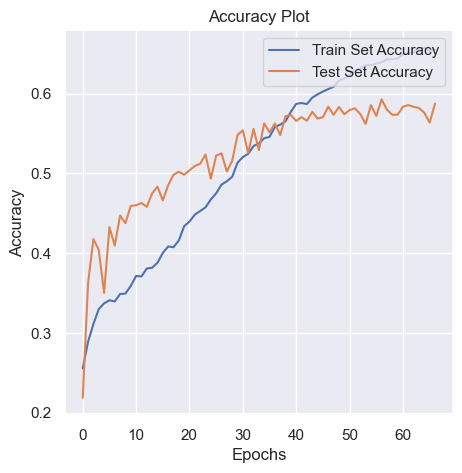

In [22]:
# Show Accuracy Graph
figure = plt.figure(figsize=(5, 5))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

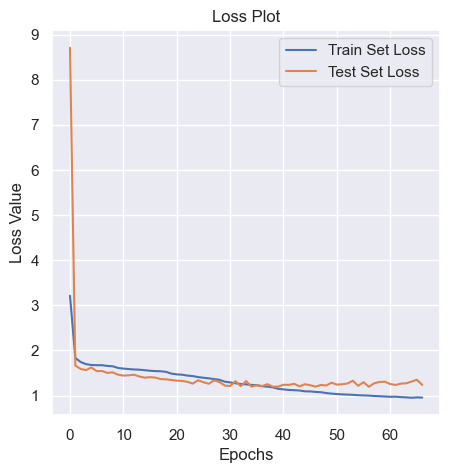

In [23]:
# Show Loss Graph 
figure2 = plt.figure(figsize=(5, 5))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

In [26]:
model = tf.keras.models.load_model('facial_recognition_detect_mood_v2_65.h5')

In [27]:
# retrained model for second time 
hist = model.fit(aug.flow(X_train, Y_train, batch_size=64), batch_size=64, epochs=90, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/90
449/449 [==============================] - ETA: 0s - loss: 1.4367 - accuracy: 0.4813
Epoch 1: val_accuracy did not improve from 0.21858
449/449 [==============================] - 170s 369ms/step - loss: 1.4367 - accuracy: 0.4813 - val_loss: 1.5628 - val_accuracy: 0.4574 - lr: 0.0010
Epoch 2/90
449/449 [==============================] - ETA: 0s - loss: 1.3934 - accuracy: 0.4964
Epoch 2: val_accuracy did not improve from 0.21858
449/449 [==============================] - 154s 344ms/step - loss: 1.3934 - accuracy: 0.4964 - val_loss: 1.4561 - val_accuracy: 0.4972 - lr: 0.0010
Epoch 3/90
449/449 [==============================] - ETA: 0s - loss: 1.3970 - accuracy: 0.4991
Epoch 3: val_accuracy did not improve from 0.21858
449/449 [==============================] - 148s 329ms/step - loss: 1.3970 - accuracy: 0.4991 - val_loss: 1.2939 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 4/90
449/449 [==============================] - ETA: 0s - loss: 1.3944 - accuracy: 0.5064
Epoch 4: val_accura

In [29]:
model.save('facial_recognition_detect_mood.h5')

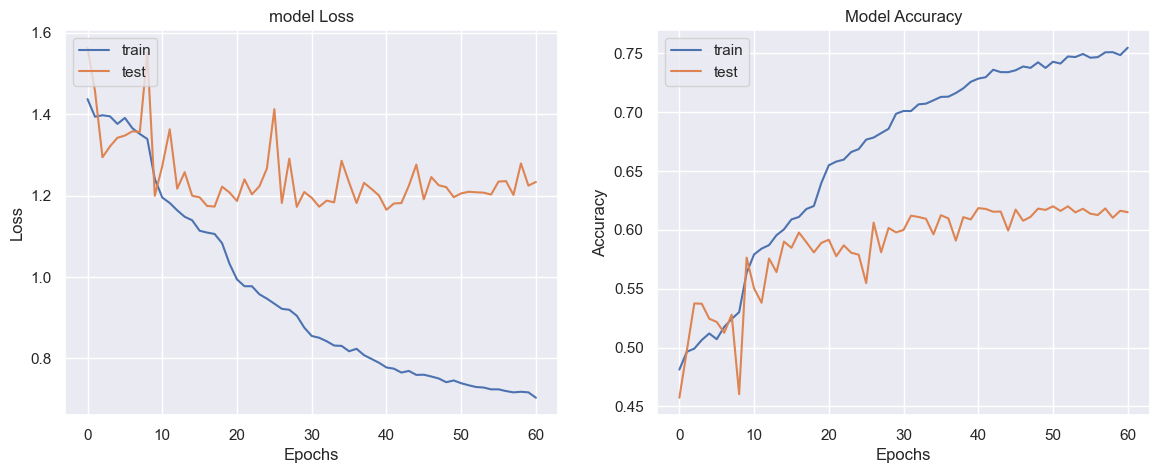

In [30]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

high accuracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can se seen in the dataset 

hence is can be concluded that the inefficiency may be due to the unbalanced dataset

# Model Evaluation¶

In [32]:
train_loss, train_accu = model.evaluate(X_train, Y_train)
test_loss, test_accu = model.evaluate(X_test, Y_test)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 8s 37ms/step - loss: 1.2052 - accuracy: 0.6199
final train accuracy = 89.15 , validation accuracy = 61.99


The model not very well in cross-val but this beacuse the data is unbalanced 

### Confusion Matrix and Classification on training set

In [63]:
def confusion_mat(X, y):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    y_target = np.argmax(y, axis=1)
    target_names = label_encoder.classes_
    
    print('Classification Report')
    target_names = label_encoder.classes_
    print(classification_report(y_target, y_pred, target_names=target_names))
    
    print('Confusion Matrix')
    cm_train = confusion_matrix(y_target , y_pred)
    print(cm_train)
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm_train, interpolation='nearest')
    plt.colorbar()
    tick_mark = np.arange(len(target_names))
    _ = plt.xticks(tick_mark, target_names, rotation=90)
    _ = plt.yticks(tick_mark, target_names)

898/898 [==============================] - 27s 30ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.88      0.86      0.87      3995
     disgust       0.98      0.81      0.89       436
        fear       0.89      0.80      0.84      4097
       happy       0.96      0.96      0.96      7215
     neutral       0.81      0.93      0.86      4965
         sad       0.92      0.83      0.87      4830
    surprise       0.88      0.95      0.91      3171

    accuracy                           0.89     28709
   macro avg       0.90      0.88      0.89     28709
weighted avg       0.89      0.89      0.89     28709

Confusion Matrix
[[3438    2   92   46  268  104   45]
 [  52  352    7    4    9    9    3]
 [ 177    2 3259   46  238  155  220]
 [  28    0   38 6926  140   12   71]
 [  44    0   58  140 4597   88   38]
 [ 165    0  157   44  421 4013   30]
 [  15    2   57   46   37    4 3010]]


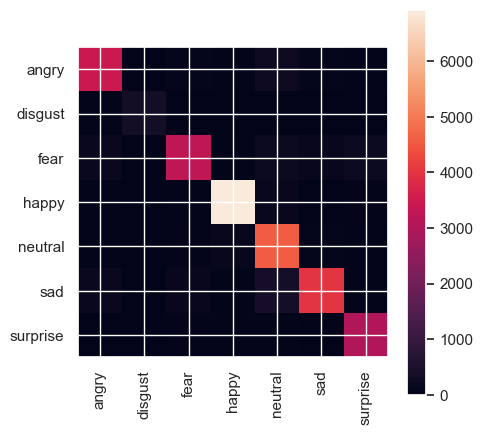

In [64]:
# Train Set
confusion_mat(X_train,Y_train)

225/225 [==============================] - 6s 28ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.51      0.53      0.52       958
     disgust       0.84      0.49      0.62       111
        fear       0.51      0.42      0.46      1024
       happy       0.82      0.82      0.82      1774
     neutral       0.53      0.65      0.59      1233
         sad       0.51      0.43      0.47      1247
    surprise       0.72      0.79      0.75       831

    accuracy                           0.62      7178
   macro avg       0.63      0.59      0.60      7178
weighted avg       0.62      0.62      0.62      7178

Confusion Matrix
[[ 508    5   91   56  143  129   26]
 [  36   54    2    4    7    6    2]
 [ 124    0  434   40  139  172  115]
 [  60    1   42 1455  121   55   40]
 [  82    1   68   94  806  140   42]
 [ 164    2  142   96  271  536   36]
 [  28    1   66   33   28   18  657]]


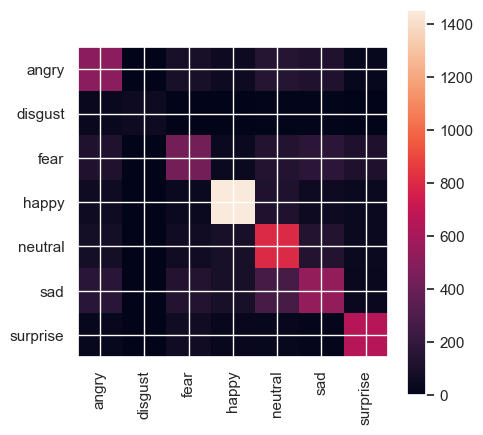

In [65]:
# Test Set
confusion_mat(X_test,Y_test)

---
# Recommend Music System


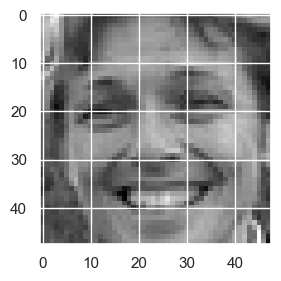

In [31]:
# Get test image
image = cv2.imread(r'Data\test\happy\PrivateTest_4518933.jpg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(3, 3))
plt.imshow(image,cmap='gray')
plt.show()

In [37]:
# Load the EmotionalMoodMusic file into a DataFrame "I Created this file"
df = pd.read_json(r"EmotionalMoodMusic.json")
df

,Angry,Disgust,Fear,Happy,Sad
0,Ya Latif,NaN,Ya Hayyu Ya Qayyum,Allah,My Ummah
1,Ya Nabi Salam Alayka,NaN,Hasbi Rabbi,For the Rest of My Life,Aman
2,Hasbi Rabbi,NaN,Forgive Me,Be Happy,Insha Allah
3,To Be with You,NaN,I Believe,Baraka Allahu Lakuma,Palestine Will Be Free
4,Alhubbu Yasood,NaN,To Be with You,This Worldly Life,Tasbih
5,The Way of Tears,NaN,Salaam,Ya Nabi Salam Alayka,Make a Prayer


In [32]:
# Reshape the image to match the model's input shape
input_frame = image.reshape(1, 48, 48, 1)

# Make a prediction
prediction = model.predict(input_frame)

1/1 [==============================] - 0s 37ms/step


In [35]:
moods = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
predicted_mood = moods[np.argmax(prediction)]
print("your mood is: ", predicted_mood)

your mode is:  Happy


In [38]:
print("I recommend you those musics")
df[[predicted_mood]]

I recommend you those musics


,Happy
0,Allah
1,For the Rest of My Life
2,Be Happy
3,Baraka Allahu Lakuma
4,This Worldly Life
5,Ya Nabi Salam Alayka


### Thanks

**By Osama Mohamed**